In [42]:
from __future__ import print_function, division
import cv2
import os
import torch
from skimage import io, transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [43]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2) # (68, 2)

In [218]:
resized_remove_alpha_smile_img.shape

(160, 160, 3)

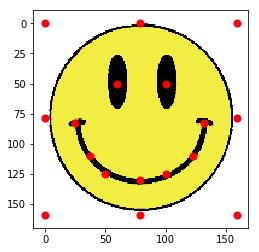

In [381]:
smile_img = io.imread('smile.jpg') # (2360, 2400, 4)
resized_remove_alpha_smile_img = cv2.resize(smile_img, (160, 160))[:,:,:3] 
plt.imshow(resized_remove_alpha_smile_img)
smile_x_p = [0, 79, 159, 0, 0, 79, 159, 159,      60, 100, 25, 37,     50,     79,   100,       123, 132]
smile_y_p = [0, 0, 0, 79, 159, 159, 79, 159,      50, 50, 83, 110,     125,   130,   125,       110, 83]
plt.scatter(smile_x_p, smile_y_p, s=200, marker='.', c='r')
plt.pause(0.001)

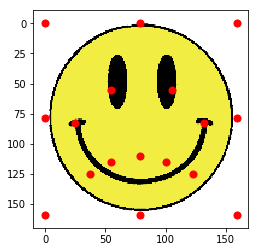

In [386]:
plt.imshow(resized_remove_alpha_smile_img)
smile_new_x_p = [0, 79, 159, 0, 0, 79, 159, 159,      55, 105,    25, 37,   55,       79,   100,     123, 132]
smile_new_y_p = [0, 0, 0, 79, 159, 159, 79, 159,      55, 55,     83, 125,  115,     110,   115,    125, 83]
plt.scatter(smile_new_x_p, smile_new_y_p, s=200, marker='.', c='r')
plt.pause(0.001)

In [330]:
# RBF 
import scipy.interpolate as interp
zfun_smooth_rbf = interp.Rbf(x_sparse, y_sparse, z_sparse_smooth, function='linear', smooth=0)  # default smooth=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(x_dense, y_dense)

# griddata
z_dense_smooth_griddata = interp.griddata(np.array([x_sparse.ravel(),y_sparse.ravel()]).T,
                                          z_sparse_smooth.ravel(),
                                          (x_dense,y_dense), method='cubic')

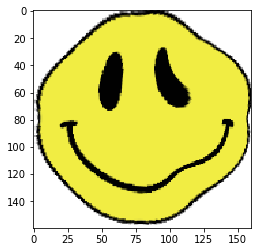

In [394]:
from scipy.interpolate import Rbf

grid_x, grid_y = np.mgrid[0:159:160j, 0:159:160j]

rbf_x = Rbf(smile_x_p, smile_y_p, smile_new_x_p, epsilon=2, function='linear', smooth=1)
ZI_x = rbf_x(grid_x, grid_y)

rbf_y = Rbf(smile_x_p, smile_y_p, smile_new_y_p, epsilon=2, function='linear', smooth=1)
ZI_y = rbf_y(grid_x, grid_y)

# source = [list(ar) for ar in zip(smile_x_p, smile_y_p)]
# destination = [list(ar) for ar in zip(smile_new_x_p, smile_new_y_p)]

# rbf_z = Rbf(source, destination, funcion='linear', smooth=1)

map_x = np.append([], [ar for ar in ZI_x]).reshape(160, 160).astype('float32')
map_y = np.append([], [ar for ar in ZI_y]).reshape(160, 160).astype('float32')
warped = cv2.remap(resized_remove_alpha_smile_img, map_y, map_x, cv2.INTER_LINEAR)
plt.imshow(warped)

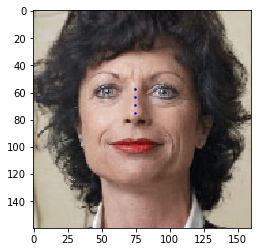

In [485]:
# 답 코드

from scipy.interpolate import Rbf

# sample transform landmarks
new_landmarks = np.copy(landmarks)
# new_landmarks[:, 0][27:31] += 5
# new_landmarks[:, 1][27:31] -= 5

grid_y, grid_x = np.mgrid[0:159:160j, 0:159:160j]

landmarks_with_zero_displacement = np.append(landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)
new_landmarks_with_zero_displacement = np.append(new_landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)

rbf_x = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:, 0], epsilon=2, function='linear', smooth=1)
ZI_x = rbf_x(grid_x, grid_y)

rbf_y = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:, 1], epsilon=2, function='linear', smooth=1)
ZI_y = rbf_y(grid_x, grid_y)

map_x = np.append([], [ar for ar in ZI_x]).reshape(160, 160).astype('float32')
map_y = np.append([], [ar for ar in ZI_y]).reshape(160, 160).astype('float32')
warped = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
plt.imshow(warped)

plt.scatter(new_landmarks[:, 0][27:31], new_landmarks[:, 1][27:31], s=10, marker='.', c='b')
plt.pause(0.001)

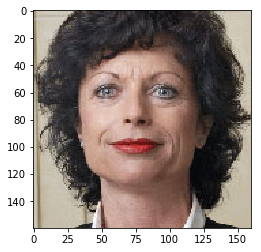

In [398]:
plt.imshow(image)

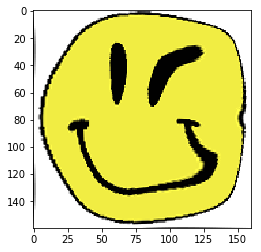

In [388]:
import cv2
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:159:160j, 0:159:160j]

source = [list(ar) for ar in zip(smile_x_p, smile_y_p)]
destination = [list(ar) for ar in zip(smile_new_x_p, smile_new_y_p)]
grid_z = griddata(destination, source, (grid_x, grid_y), method='cubic')
map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(160, 160).astype('float32')
map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(160, 160).astype('float32')
warped = cv2.remap(resized_remove_alpha_smile_img, map_x, map_y, cv2.INTER_CUBIC)
plt.imshow(warped)

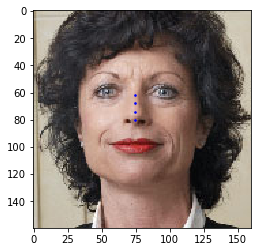

In [425]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0][27:31], landmarks[:, 1][27:31] + 5, s=10, marker='.', c='b')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

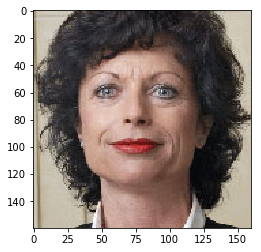

In [155]:
plt.imshow(image)

In [421]:
new_landmarks = np.copy(landmarks)
new_landmarks[:, 1][27:31] += 5
new_landmarks

array([[  32.,   65.],
       [  33.,   76.],
       [  34.,   86.],
       [  34.,   97.],
       [  37.,  107.],
       [  41.,  116.],
       [  50.,  122.],
       [  61.,  126.],
       [  72.,  127.],
       [  83.,  126.],
       [  95.,  123.],
       [ 107.,  119.],
       [ 115.,  111.],
       [ 118.,  101.],
       [ 120.,   91.],
       [ 122.,   80.],
       [ 122.,   68.],
       [  39.,   52.],
       [  45.,   46.],
       [  53.,   44.],
       [  61.,   46.],
       [  68.,   49.],
       [  82.,   49.],
       [  90.,   45.],
       [  98.,   44.],
       [ 106.,   46.],
       [ 112.,   52.],
       [  74.,   62.],
       [  74.,   68.],
       [  74.,   74.],
       [  74.,   80.],
       [  67.,   83.],
       [  70.,   84.],
       [  74.,   85.],
       [  78.,   84.],
       [  82.,   83.],
       [  47.,   61.],
       [  51.,   57.],
       [  58.,   57.],
       [  63.,   61.],
       [  57.,   63.],
       [  51.,   63.],
       [  87.,   62.],
       [  9

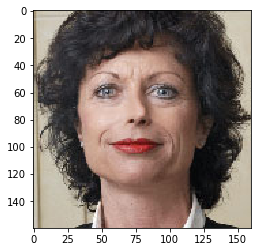

In [431]:
import cv2
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:159:160j, 0:159:160j]
source = np.append(landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)
#destination = np.append(landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)
destination = np.append(new_landmarks, [[0,0], [0, 80], [0, 159], [80, 0], [159,0], [159, 80], [159, 159], [80, 159]], axis=0)
grid_z = griddata(destination, source, (grid_x, grid_y), method='cubic')
map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(160, 160).astype('float32')
map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(160, 160).astype('float32')
warped = cv2.remap(image, map_x, map_y, cv2.INTER_CUBIC)
plt.imshow(warped)

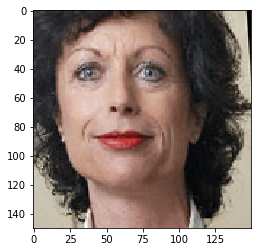

In [154]:
import cv2
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:149:150j, 0:149:150j]
destination = np.array([[0,0], [0,49], [0,99], [0,149],
                  [49,0],[49,49],[49,99],[49,149],
                  [99,0],[99,49],[99,99],[99,149],
                  [149,0],[149,49],[149,99],[149,149]])
source = np.array([[22,22], [24,68], [26,116], [25,162],
                  [64,19],[65,64],[65,114],[64,159],
                  [107,16],[108,62],[108,111],[107,157],
                  [151,11],[151,58],[151,107],[151,156]])
grid_z = griddata(destination, source, (grid_x, grid_y), method='cubic')
map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(150,150)
map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(150,150)
map_x_32 = map_x.astype('float32')
map_y_32 = map_y.astype('float32')

# orig = cv2.imread(os.path.join('faces/', img_name))
warped = cv2.remap(image, map_x_32, map_y_32, cv2.INTER_CUBIC)
plt.imshow(warped)
# cv2.imwrite("warped.png", warped)

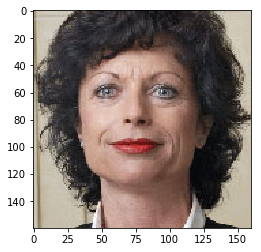

In [82]:
plt.imshow(image)